[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Bolin_1958/timescales_comparison.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Bolin_1958/timescales_comparison.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Bolin_1958/timescales_comparison.ipynb)

#### Timescales comparison 
##### Bolin
##### Gedzelman
- TODO urls
- TODO alpha?

In [145]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [146]:
import numpy as np
from PySDM.physics import si, in_unit
from PySDM import Formulae
from PySDM_examples.Bolin_1958.common import IsotopeTimescale
from open_atmos_jupyter_utils import show_plot
import pandas as pd
import matplotlib.pyplot as plt

In [147]:
def e_fold_timescale(it, isotope, temperature, radii, RH, R_vap, alpha):
    c1_coeff = it.c1(
        isotope=isotope,
        R_vap=R_vap, 
        RH=RH,
        pv_iso=1,
        pv_water=1,
        alpha=R_liq/R_vap,
    )
    return it.formulae.isotope_relaxation_timescale.tau_of_rdrdt_c1(
        radius = radii,
        r_dr_dt = it.r_dr_dt(RH=RH, RH_eq=1, lv=0),
        c1_coeff = c1_coeff
    )
    

In [148]:
any_non_zero_value = 44.0
radii = np.asarray([0.005, 0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.20]) * si.cm
temperature = Formulae().constants.T0 + 10 * si.K
R_vap = 0.75
settings = {
    "terminal_velocity":"RogersYau",
    "drop_growth":"Mason1951",
    "diffusion_thermics":"Neglect",
    "saturation_vapour_pressure":"AugustRocheMagnus",
    "ventilation":"Froessling1938",
    "particle_shape_and_density":"LiquidSpheres",
    "air_dynamic_viscosity":"ZografosEtAl1987",
    "isotope_equilibrium_fractionation_factors":"VanHook1968",
    "isotope_diffusivity_ratios":"GrahamsLaw"
}

variants = {
    'bolin_c1': {
        'constants': {"BOLIN_ISOTOPE_TIMESCALE_COEFF_C1": 1.63},
        'isotope_relaxation_timescale': "Bolin1958",
    },
    'miyake': {
        'isotope_relaxation_timescale': "MiyakeEtAl1968",
    },
    'zaba_and_arabas': {
        'isotope_relaxation_timescale': "ZabaAndArabas2025",
    }
}

adjustment_time = {}

## Miyake

In [149]:
iso_func = IsotopeTimescale(settings={**settings, **variants['miyake']}, temperature=temperature, radii=radii)
R_liq =  1
adjustment_time['miyake'] = iso_func.formulae.isotope_relaxation_timescale.tau_of_rdrdt(
    radius = radii,
    r_dr_dt = iso_func.r_dr_dt(RH=0, RH_eq=1, lv=0),
    alpha= 1#/0.75#R_liq/R_vap
)

## Bolin - check his c1 value

In [150]:
iso_func = IsotopeTimescale(settings={**settings, **variants['bolin_c1']}, temperature=temperature, radii=radii)
rh = 0.46 #arbitrary?
vent_coeff = iso_func.vent_coeff_fun()
c1_coeff = iso_func.formulae.isotope_relaxation_timescale.c1_coeff(   
    RH = rh,
    R_vap = R_vap,
    
)
print(f"c1 = {c1_coeff:.2f},\nBolin = {iso_func.formulae.constants.BOLIN_ISOTOPE_TIMESCALE_COEFF_C1}")
adjustment_time['bolin'] = iso_func.formulae.isotope_relaxation_timescale.tau_of_rdrdt_c1(
    radius = radii,
    r_dr_dt = iso_func.r_dr_dt(RH=rh, RH_eq=1, lv=0),
    c1_coeff = c1_coeff
)

c1 = 1.63,
Bolin = 1.63


# Zaba and Arabas


In [151]:
it_zaba = IsotopeTimescale(settings={**settings, **variants['zaba_and_arabas']}, temperature=temperature, radii=radii)
rh = 0
R_vap = 0.75
isotope = '3H'
D_isotope = getattr(it_zaba.formulae.isotope_diffusivity_ratios, f"ratio_{isotope}")(temperature)  * it_zaba.D
adjustment_time['zaba_and_arabas'] = it_zaba.formulae.isotope_relaxation_timescale.tau(
    it_zaba.formulae.constants,
    radius=radii,
    alpha_env=getattr(it_zaba.formulae.isotope_equilibrium_fractionation_factors, f"alpha_l_{isotope}")(temperature),
    D_iso=it_zaba.D,
    vent_coeff_iso=it_zaba.vent_coeff_fun(),
    k_coeff_iso=1,
    e_s =it_zaba.formulae.saturation_vapour_pressure.pvs_water(temperature),
    saturation=rh,
    R_vap_env=1,
    temperature=temperature,
    M_iso=it_zaba.formulae.constants.Mv#getattr(it_zaba.formulae.constants, f"M_{isotope}"),
)

Rh = 0.9

In [169]:
it_zaba = IsotopeTimescale(settings={**settings, **variants['zaba_and_arabas']}, temperature=temperature, radii=radii)
rh = 0.85
R_vap = 0.75
isotope = '3H'
D_isotope = getattr(it_zaba.formulae.isotope_diffusivity_ratios, f"ratio_{isotope}")(temperature)  * it_zaba.D
adjustment_time['zaba_and_arabas_rh0.85'] = it_zaba.formulae.isotope_relaxation_timescale.tau(
    it_zaba.formulae.constants,
    radius=radii,
    alpha_env=getattr(it_zaba.formulae.isotope_equilibrium_fractionation_factors, f"alpha_l_{isotope}")(temperature),
    D_iso=it_zaba.D,
    vent_coeff_iso=it_zaba.vent_coeff_fun(),
    k_coeff_iso=1,
    e_s =it_zaba.formulae.saturation_vapour_pressure.pvs_water(temperature),
    saturation=rh,
    R_vap_env=1,
    temperature=temperature,
    M_iso=it_zaba.formulae.constants.Mv#getattr(it_zaba.formulae.constants, f"M_{isotope}"),
)

In [153]:
it_zaba = IsotopeTimescale(settings={**settings, **variants['zaba_and_arabas']}, temperature=temperature, radii=radii)
rh = 0
R_vap = 0.75
isotope = '2H'
D_isotope = getattr(it_zaba.formulae.isotope_diffusivity_ratios, f"ratio_{isotope}")(temperature)  * it_zaba.D
adjustment_time['zaba_and_arabas_2'] = it_zaba.formulae.isotope_relaxation_timescale.tau(
    it_zaba.formulae.constants,
    radius=radii,
    alpha_env=getattr(it_zaba.formulae.isotope_equilibrium_fractionation_factors, f"alpha_l_{isotope}")(temperature),
    D_iso=it_zaba.D,
    vent_coeff_iso=it_zaba.vent_coeff_fun(),
    k_coeff_iso=1,
    e_s =it_zaba.formulae.saturation_vapour_pressure.pvs_water(temperature),
    saturation=rh,
    R_vap_env=1,
    temperature=temperature,
    M_iso=it_zaba.formulae.constants.Mv#getattr(it_zaba.formulae.constants, f"M_{isotope}"),
)

## Bolin without RH = 0 assumption

In [154]:
RH = 0.9
c1_coeff = iso_func.c1(
    isotope="3H",
    R_vap=R_vap, 
    RH=RH,
    pv_iso=1,
    pv_water=1,
    alpha=R_liq/R_vap,
)
print(f"c1 = {c1_coeff[0]:.2f}")
adjustment_time[f'RH={RH}'] = iso_func.formulae.isotope_relaxation_timescale.tau_of_rdrdt_c1(
    radius = radii,
    r_dr_dt = iso_func.r_dr_dt(RH=RH, RH_eq=1, lv=0),
    c1_coeff = c1_coeff
)

c1 = 3.93


In [155]:
isotopes = ("3H", "2H")
R_vap = 0.75
R_liq = 1 
rh_all = np.linspace(0,0.9, 6)

for isotope in isotopes:
    for rh in rh_all:
        c1_coeff = iso_func.c1(
            isotope=isotope,
            R_vap=R_vap, 
            RH=rh,
            pv_iso=1,
            pv_water=1,
            alpha=R_liq/R_vap,
        )
        adjustment_time[f'isotope={isotope}, rh={rh:.3g}'] = iso_func.formulae.isotope_relaxation_timescale.tau_of_rdrdt_c1(
            radius = iso_func.radii,
            r_dr_dt = iso_func.r_dr_dt(RH=rh, RH_eq=1, lv=0),
            c1_coeff = c1_coeff
        )

--- 
## Bolin's Table 1.

In [156]:
adjustment_time_bolin = np.asarray((3.3, 7.1, 33.0, 93.0, 165.0, 245.0, 365.0, 435.0)) * si.s
terminal_velocity = np.asarray((0.27, 0.72, 2.1, 4.0, 5.4, 6.5, 8.1, 8.8)) * si.m / si.s
distance = np.asarray((0.9, 5.1, 69.0, 370.0, 890.0, 1600.0, 3000.0, 3800.0)) * si.m

In [157]:
bolin_table_1 = pd.DataFrame({
    'Radius [cm]': in_unit(radii, si.cm),
    'Adjustment time [s]': adjustment_time_bolin,
    'Terminal velocity [m/s]': terminal_velocity,
    'Distance [m]': distance,
})
bolin_table_1

,Radius [cm],Adjustment time [s],Terminal velocity [m/s],Distance [m]
0,0.005,3.3,0.27,0.9
1,0.010,7.1,0.72,5.1
2,0.025,33.0,2.10,69.0
3,0.050,93.0,4.00,370.0
4,0.075,165.0,5.40,890.0
5,0.100,245.0,6.50,1600.0
6,0.150,365.0,8.10,3000.0
7,0.200,435.0,8.80,3800.0


In [158]:
adjustment_time_frame = pd.DataFrame({
    'Radius [cm]' : in_unit(radii, si.cm),
    'Miyake' : adjustment_time['miyake'],
    #'RH_env=0.9': adjustment_time['RH=0.9'],
    'Zaba & Arabas': adjustment_time['zaba_and_arabas'],
    #'Z&A RH=0.9': adjustment_time['zaba_and_arabas_rh0.9'],
    'Z&A 2H': adjustment_time['zaba_and_arabas_2'],
})
for rh in rh_all:
    #adjustment_time_frame[f"RH_env={rh}_2H"] = adjustment_time[f'isotope=2H, rh={rh:.3g}']
    #adjustment_time_frame[f"RH_env={rh}_3H"] = adjustment_time[f'isotope=3H, rh={rh:.3g}']
    continue

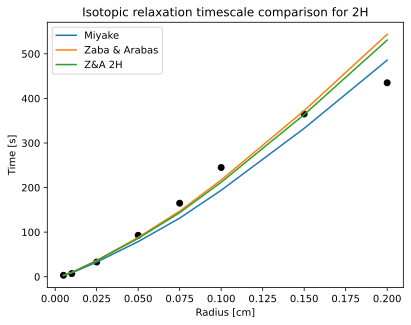

In [159]:
fig, ax = plt.subplots()
for variant, time in adjustment_time_frame.items():
    if variant != 'Radius [cm]':
        ax.plot(in_unit(radii, si.cm), time * si.s, label=variant)
ax.scatter(in_unit(radii, si.cm), bolin_table_1['Adjustment time [s]'], color='k')
ax.set_title(f'Isotopic relaxation timescale comparison ')
ax.set_xlabel('Radius [cm]')
ax.set_ylabel('Time [s]')
ax.legend()
show_plot('timescales_comparison.pdf')

In [170]:
adjustment_time_frame = pd.DataFrame({
    'Radius [cm]' : in_unit(radii, si.cm),
    #'Miyake' : adjustment_time['miyake'],
    'RH_env=0.9': adjustment_time['RH=0.9'],
    #'Zaba & Arabas': adjustment_time['zaba_and_arabas'],
    'Z&A RH=0.9': adjustment_time['zaba_and_arabas_rh0.9'],
    'Z&A RH=0.5': adjustment_time['zaba_and_arabas_rh0.5'],
    'Z&A RH=0.7': adjustment_time['zaba_and_arabas_rh0.7'],
    'Z&A RH=0.8': adjustment_time['zaba_and_arabas_rh0.8'],
    'Z&A RH=0.85': adjustment_time['zaba_and_arabas_rh0.85'],
    #'Z&A 2H': adjustment_time['zaba_and_arabas_2'],
})
for rh in rh_all:
    #adjustment_time_frame[f"RH_env={rh}_2H"] = adjustment_time[f'isotope=2H, rh={rh:.3g}']
    #adjustment_time_frame[f"RH_env={rh}_3H"] = adjustment_time[f'isotope=3H, rh={rh:.3g}']
    continue

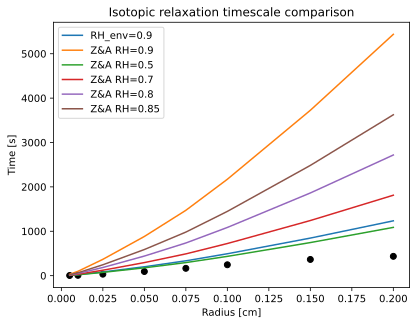

In [171]:
fig, ax = plt.subplots()
for variant, time in adjustment_time_frame.items():
    if variant != 'Radius [cm]':
        ax.plot(in_unit(radii, si.cm), time * si.s, label=variant)
ax.scatter(in_unit(radii, si.cm), bolin_table_1['Adjustment time [s]'], color='k')
ax.set_title(f'Isotopic relaxation timescale comparison')
ax.set_xlabel('Radius [cm]')
ax.set_ylabel('Time [s]')
ax.legend()
show_plot('timescales_comparison.pdf')

## 

# iso_env 
# 3 izotopy!
# RH 